In [1]:
import clmm
from clmm import Cosmology
from clmm.support import mock_data as mock
from clmm.galaxycluster import GalaxyCluster
import matplotlib.pyplot as plt
import sys
import clmm.utils as u

/home/cdavies/.local/lib/python3.9/site-packages/clmm-1.0.1-py3.9.egg/clmm/theory/__init__.py:38: UserWarning: CLMM Backend requested `ccl' is not available, trying others...
/home/cdavies/.local/lib/python3.9/site-packages/clmm-1.0.1-py3.9.egg/clmm/theory/__init__.py:45: UserWarning: * USING NumCosmo BACKEND


Make sure we know which version we're using

In [2]:
clmm.__version__

'1.0.1'

### Define cosmology object

In [3]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

First, we want to generate a $\Delta\Sigma$ (excess surface density) profile from mock data, to which we can apply boost factors. The mock data is generated in the following cells.

Generate cluster object from mock data

In [4]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15
cluster_z = 0.3
concentration = 4
ngals = 1000

zsrc_min = cluster_z + 0.1 # we only want to draw background galaxies

noisy_data_z = mock.generate_galaxy_catalog(cluster_m,
                                            cluster_z,
                                            concentration,
                                            cosmo,
                                            'chang13',
                                            zsrc_min=zsrc_min,
                                            shapenoise=0.005,
                                            photoz_sigma_unscaled=0.05, ngals=ngals)

Loading this into a CLMM cluster object centered on (0,0)

In [5]:
cluster_ra = 0.0
cluster_dec = 0.0
cl = GalaxyCluster(cluster_id, cluster_ra, cluster_dec, 
                               cluster_z, noisy_data_z)

Compute cross and tangential excess surface density for each source galaxy

In [6]:
cl.compute_tangential_and_cross_components(geometry="flat",
                                                      shape_component1='e1', shape_component2='e2', 
                                                      tan_component='DeltaSigma_tan', cross_component='DeltaSigma_cross',
                                                      add=True, cosmo=cosmo, is_deltasigma=True)

(array([0.00480637, 0.00148025, 0.00431649, 0.00371775, 0.00362752,
        0.00333458, 0.00349172, 0.00224586, 0.00302981, 0.00145909,
        0.00205744, 0.00242088, 0.0032826 , 0.00327451, 0.00536155,
        0.00489616, 0.00322317, 0.00443612, 0.00263808, 0.00224163,
        0.00457883, 0.00417343, 0.00108272, 0.00220351, 0.0018456 ,
        0.00535643, 0.00062041, 0.0051858 , 0.00370772, 0.00502373,
        0.00359803, 0.00337406, 0.00518879, 0.00175626, 0.00366154,
        0.00329891, 0.00492947, 0.00467155, 0.00595164, 0.00411671,
        0.00354416, 0.00226423, 0.00200125, 0.00349361, 0.00403254,
        0.00345462, 0.00234738, 0.00443277, 0.0032777 , 0.00225738,
        0.00203001, 0.00347585, 0.00432047, 0.00596154, 0.00336757,
        0.00440892, 0.00101402, 0.00374526, 0.00351622, 0.00063493,
        0.0026346 , 0.00381989, 0.00265004, 0.00214121, 0.00498714,
        0.00346316, 0.00464841, 0.00283323, 0.00394783, 0.00486493,
        0.00445416, 0.00504721, 0.00397715, 0.00

Calculate the binned profile

In [7]:
cl.make_radial_profile("kpc", cosmo=cosmo, 
                       tan_component_in='DeltaSigma_tan', cross_component_in='DeltaSigma_cross',
                       tan_component_out='DeltaSigma_tan', cross_component_out='DeltaSigma_cross',
                       table_name='DeltaSigma_profile')
cl.DeltaSigma_profile.show_in_notebook()

idx,radius_min,radius,radius_max,DeltaSigma_tan,DeltaSigma_tan_err,DeltaSigma_cross,DeltaSigma_cross_err,z,z_err,n_src
0,333.53208460490794,578.0691492993726,856.0046098330793,172030973520562.53,6188511627269.913,-3437473651006.848,3399856189659.599,1.2156009426537921,0.1115194553129768,26
1,856.0046098330793,1131.815160716345,1378.4771350612505,99376587714559.88,2565557991740.934,-1614464393985.112,2270652024732.244,1.2372735914730848,0.09352827188321572,66
2,1378.4771350612505,1697.1775571748362,1900.949660289422,69180913169306.0,2105493303342.424,492201724420.92004,1826246760812.4004,1.1201273709421518,0.0625496299931679,90
3,1900.949660289422,2182.818725988231,2423.4221855175933,51640531232373.39,1419694442697.5115,-1297910991593.305,1415649916046.235,1.2014382666694086,0.06383140450906181,116
4,2423.4221855175933,2686.287580847939,2945.8947107457648,42266767302953.88,1698457787066.013,148782188960.5762,1540550521241.5015,1.1953273244864422,0.05608307564408975,128
5,2945.8947107457648,3209.3212147513714,3468.3672359739357,31549255269560.87,1138885516917.8804,-1086634594952.0948,1142677964671.3088,1.2177703539252218,0.044301057676294,177
6,3468.3672359739357,3729.662212498418,3990.839761202107,30871290513903.49,1731747892472.23,73940329589.17926,1188895110437.9133,1.2572559035690556,0.05194668473343034,165
7,3990.839761202107,4206.080128329993,4513.312286430279,22869437489523.746,1422043439322.3074,-862971792453.7897,1389799038047.3943,1.2228743961855806,0.05244460234026638,142
8,4513.312286430279,4764.6423777907285,5035.78481165845,22686487929971.05,2558946281971.011,-83313846619.57103,2914110901751.58,1.1083832184120643,0.0747615791459556,74
9,5035.78481165845,5231.748264878101,5558.2573368866215,22719135606264.73,7812987529528.329,1336580141565.814,3183462115463.4927,1.1113479127266865,0.1541950080401256,16


Plot the $\Delta\Sigma$ profile

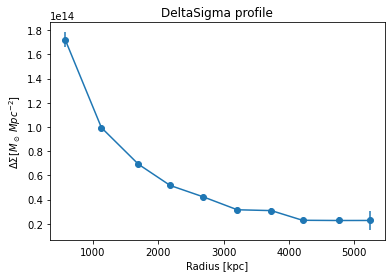

In [8]:
plt.errorbar(cl.DeltaSigma_profile['radius'], cl.DeltaSigma_profile['DeltaSigma_tan'],
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o')
plt.title('DeltaSigma profile')
plt.xlabel("Radius [kpc]")
plt.ylabel('$\Delta\Sigma [M_\odot\; Mpc^{-2}]$')
plt.show()

## Boost Factors

CLMM offers two boost models, the NFW boost model, and a powerlaw boost model. 

Note that `compute_nfw_boost` requires two parameters to be specified, `rs` and `b0`, and `compute_powerlaw_boost` requires three paramters, `rs`, `b0` and `alpha`. The default values are in kpc. 

Details on these boost models can be found [here](https://cluster-toolkit.readthedocs.io/en/latest/source/boostfactors.html)

First, we can calculate the boost factors from the two models.

In [10]:
nfw_boost = u.compute_nfw_boost(cl.DeltaSigma_profile['radius'],rs=1000, b0=0.1)

powerlaw_boost = u.compute_powerlaw_boost(cl.DeltaSigma_profile['radius'],rs=1000, b0=0.1, alpha=-1.0)

Plot the two boost factors, $B(R)$

/home/cdavies/miniconda3/envs/clmm_boost/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


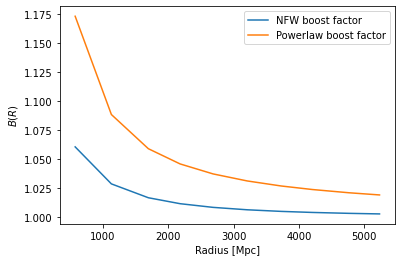

In [11]:
plt.plot(cl.DeltaSigma_profile['radius'],nfw_boost,label='NFW boost factor')
plt.plot(cl.DeltaSigma_profile['radius'],powerlaw_boost,label='Powerlaw boost factor')
plt.xlabel("Radius [Mpc]")
plt.ylabel("$B(R)$")
plt.legend()
plt.show()

The $\Delta\Sigma$ profiles can be corrected with the boost factor using `correct_sigma_with_boost_values` or `correct_sigma_with_boost_model`. 

`correct_sigma_with_boost_values` requires us to precompute the boost factor, e.g. using `compute_nfw_boost`.
`correct_sigma_with_boost_model` simply requires us to specify the boody model.

First we will apply the boost factor with `correct_sigma_with_boost_values`

In [12]:
#nfw_boost = u.compute_nfw_boost(cl.DeltaSigma_profile['radius'],rs=1000, b0=0.1)

#powerlaw_boost = u.compute_powerlaw_boost(cl.DeltaSigma_profile['radius'],rs=1000, b0=0.1, alpha=-1.0)

#We would usually have to precompute the boost factors one of the above lines of code 
#but this has already been done in a previous cell

Sigma_corrected_powerlaw_boost = u.correct_sigma_with_boost_values(cl.DeltaSigma_profile['radius'],
                                                                   cl.DeltaSigma_profile['DeltaSigma_tan'],
                                                                   powerlaw_boost)
Sigma_corrected_nfw_boost = u.correct_sigma_with_boost_values(cl.DeltaSigma_profile['radius'],
                                                              cl.DeltaSigma_profile['DeltaSigma_tan'],
                                                              nfw_boost)

Plot the result

/home/cdavies/miniconda3/envs/clmm_boost/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/cdavies/.local/lib/python3.9/site-packages/numpy-1.21.2-py3.9-linux-x86_64.egg/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


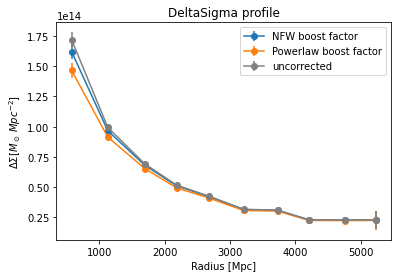

In [13]:
plt.errorbar(cl.DeltaSigma_profile['radius'], Sigma_corrected_nfw_boost,
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='NFW boost factor')

plt.errorbar(cl.DeltaSigma_profile['radius'], Sigma_corrected_powerlaw_boost,
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='Powerlaw boost factor')

plt.errorbar(cl.DeltaSigma_profile['radius'], cl.DeltaSigma_profile['DeltaSigma_tan'],
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='uncorrected',color='grey')

#plt.loglog()
plt.title('DeltaSigma profile')
plt.xlabel("Radius [Mpc]")
plt.ylabel('$\Delta\Sigma [M_\odot\; Mpc^{-2}]$')
plt.legend()
plt.show()

Now the same again but with `correct_sigma_with_boost_model`

/home/cdavies/miniconda3/envs/clmm_boost/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/cdavies/.local/lib/python3.9/site-packages/numpy-1.21.2-py3.9-linux-x86_64.egg/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


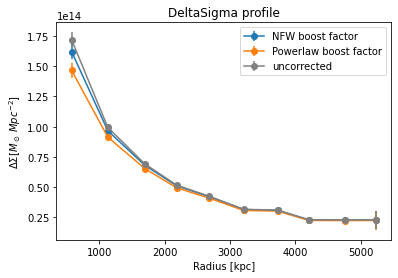

In [14]:
Sigma_corrected_powerlaw_boost = u.correct_sigma_with_boost_model(cl.DeltaSigma_profile['radius'],
                                                                   cl.DeltaSigma_profile['DeltaSigma_tan'],
                                                                   boost_model='powerlaw_boost')
Sigma_corrected_nfw_boost = u.correct_sigma_with_boost_model(cl.DeltaSigma_profile['radius'],
                                                              cl.DeltaSigma_profile['DeltaSigma_tan'],
                                                              boost_model='nfw_boost')

plt.errorbar(cl.DeltaSigma_profile['radius'], Sigma_corrected_nfw_boost,
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='NFW boost factor')

plt.errorbar(cl.DeltaSigma_profile['radius'], Sigma_corrected_powerlaw_boost,
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='Powerlaw boost factor')

plt.errorbar(cl.DeltaSigma_profile['radius'], cl.DeltaSigma_profile['DeltaSigma_tan'],
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='uncorrected',color='grey')

#plt.loglog()
plt.title('DeltaSigma profile')
plt.xlabel("Radius [kpc]")
plt.ylabel('$\Delta\Sigma [M_\odot\; Mpc^{-2}]$')
plt.legend()
plt.show()